In [101]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import torch
import random
import os
from torch.utils.data import Dataset, DataLoader
from torch import nn
import albumentations as A
from torch.utils.data.sampler import WeightedRandomSampler
from ignite.metrics import Recall, Precision, Accuracy
from sklearn import metrics
import codecs
from efficientnet_pytorch import model as enet
from sklearn.model_selection import StratifiedKFold

In [102]:
torch.cuda.empty_cache()

### Config

In [103]:
conf_dict = {
    "batch_size": 8,
    "learn_rate": 1e-3,
    "min_learn_rate": 1e-6,
    "weight_decay": 1e-4,
    "epochs": 10,
    "folds": 5,

    "transfer_model_name": "efficientnet-b1",
    "model": "schnaufnet_trained",
    "model_to_load": "schnaufnet_trained.pth",

    "input_dir": "../input/seti-breakthrough-listen/",
    "train_dir": "../input/seti-breakthrough-listen/train/",
    "train_csv": "train_labels.csv",
    "test_dir": "../input/seti-breakthrough-listen/test/",
    "test_csv": "sample_submission.csv",
    "efficientnetdir": "../input/efficientnetpytorch/",
    "height": 256,
    "width": 256,

    "origin_height": 273,
    "origin_width": 256,

    "use_all": True,
    "only_use": 1000,
    "behaviours": {
        "all": "all",
        "weighted": "weighted",
    },
    "split_until_ratio": (3 / 4),
    "load_model": False,
}
current_split_behaviour = conf_dict["behaviours"]["weighted"]
new_split_behaviour = conf_dict["behaviours"]["all"]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [104]:
def set_seed(seed=0):
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    return random_state

random_state = set_seed(2021)

### Custom Dataset

In [105]:
class SETIDataset(Dataset):
	"""Dataset for training data"""
	def __init__(self, df, transform=None):
		self.df = df
		self.labels = self.df["target"].values
		self.file_names = self.df['file_path'].values
		self.transform = transform

	def __len__(self):
		return len(self.df)

	def __getitem__(self, idx):
		file_path = self.file_names[idx]
		image = np.load(file_path)
		image = image.astype(np.float32)
		image = np.vstack(image).T
		if self.transform:
			image = self.transform(image=image)['image']
		else:
			image = image[np.newaxis,:,:] # add dimension
			image = torch.from_numpy(image).float()
		image = torch.from_numpy(image).unsqueeze(dim=0)
		label = torch.tensor(self.labels[idx]).float()
		return image, label

In [106]:
class EfficientNetBackbone(nn.Module):
    def __init__(self, out_dim, load_schnaufnet_model=False):
        super(EfficientNetBackbone, self).__init__()
        print("Initializing Efficientnet Backbone")
        model_name = conf_dict["transfer_model_name"]
        self.efficientnet = enet.EfficientNet.from_pretrained(model_name)
        if load_schnaufnet_model:
            print("Loading pretrained schnaufnet model")
            model.load_state_dict(torch.load(conf_dict["model_to_load"]))
        self.first_layer = nn.Conv2d(1, 3, kernel_size=3, stride=1, padding=3, bias=False)
        self.final_layer = nn.Linear(self.efficientnet._fc.in_features, out_dim)
        self.efficientnet._fc = nn.Identity()

    def extract(self, x):
        return self.efficientnet(x)

    def forward(self, x):
        x = self.first_layer(x)
        x = self.extract(x)
        x = self.final_layer(x)
        return x

In [107]:
def split(train_index, val_index, behaviour="all"):
    train_df, val_df = df_train.iloc[train_index], df_train.iloc[val_index]
    
    dataset_train = SETIDataset(train_df, transform=get_transforms(data="train"))
    dataset_val = SETIDataset(val_df, transform=get_transforms(data="val"))

    if behaviour == conf_dict["behaviours"]["weighted"]:
        print("Using 50/50 weighted data...")
        labels = np.array(dataset_train.labels)
        class_counts = np.array(
            [len(np.where(labels == t)[0]) for t in np.unique(labels)])
        num_samples = sum(class_counts)
        class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
        weights = [class_weights[labels[i]] for i in range(int(num_samples))]
        sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))
        train_dataloader = DataLoader(
            dataset_train, batch_size=conf_dict["batch_size"], sampler=sampler)
    elif behaviour == conf_dict["behaviours"]["all"]:
        print("Using original full data...")
        train_dataloader = DataLoader(
            dataset_train, batch_size=conf_dict["batch_size"], shuffle=True)#, num_workers=2)
    val_dataloader = DataLoader(dataset_val, batch_size=conf_dict["batch_size"], shuffle=True)#, num_workers=2)
    print(f"Successfully splitted dataset!\n Trainbatches: {len(train_dataloader)}\n Validationbatches: {len(val_dataloader)}")
    return train_dataloader, val_dataloader

def get_0_1_batches_ratio(dataloader):
    print("dataloader length: ", len(dataloader))
    for i, (data, target) in enumerate(dataloader):
        print (f"batch index {i}, 0/1: {len(np.where(target.numpy() == 0)[0])}/{len(np.where(target.numpy() == 1)[0])}")

def get_0_1_ratio(dataloader, train):
    dataloader_0 = 0
    dataloader_1 = 0
    for i, (data, target) in enumerate(tqdm(dataloader)):
        dataloader_0 += len(np.where(target.numpy() == 0)[0])
        dataloader_1 += len(np.where(target.numpy() == 1)[0])
    dataloaderinformation = "train" if train else "val"
    print(f"{dataloaderinformation} dataloader 0/1 ratio: {dataloader_0}, {dataloader_1}")
    return train_dataloader, val_dataloader

In [108]:
def train_loop(model, train_dataloader, optimizer, loss_fn, scheduler, epoch_loss_list):
    print("Starting model training...")
    model.train()
    epoch_loss = 0
    num_batches = len(train_dataloader)

    accuracy = Accuracy()
    precision = Precision()
    recall = Recall()

    for (images, labels) in tqdm(train_dataloader, position=0, leave=True, desc='Training'):
        images = images.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.float)

        optimizer.zero_grad()
        pred = model(images)
        loss = loss_fn(pred.view(labels.size(0)), labels.to(torch.float32))
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        predicted = torch.sigmoid(pred).round()
        accuracy.update((predicted, labels))
        precision.update((predicted, labels))
        recall.update((predicted, labels))

    avg_epoch_loss = epoch_loss / num_batches
    epoch_loss_list.append(avg_epoch_loss)
    print(f"""Training Error: \n 
        Accuracy: {100*accuracy.compute():>2f}%, \n
        Recall: {100*recall.compute():>2f}%, \n
        Precision: {100*precision.compute():>2f}%, \n
        Avg loss: {avg_epoch_loss:>2f} \n
    """)
    with codecs.open('logs/schnaufNet2.0 train.log', 'a') as up:
        up.write(f"""Validation Error: \n
            Accuracy: {100*accuracy.compute():2f}%, \n
            Recall: {100*recall.compute():2f}%, \n
            Precision: {100*precision.compute():>2f}%, \n
            Avg loss: {avg_epoch_loss:>2f} \n
        """)

def validation_loop(model, val_dataloader, loss_fn):
    print("Starting model validation...")
    model.eval()

    epoch_loss = 0
    num_batches = len(val_dataloader)
    epoch_labels = []
    epoch_preds = []

    accuracy = Accuracy()
    precision = Precision()
    recall = Recall()

    with torch.no_grad():
        for (images, labels) in tqdm(val_dataloader, position=0, leave=True, desc='Evaluating'):
            images = images.to(device)
            labels = labels.to(device)

            pred = model(images)
            loss = loss_fn(pred.view(labels.size(0)), labels.to(torch.float32))
            epoch_loss += loss.item()

            predicted_raw = torch.sigmoid(pred)
            predicted = predicted_raw.round()

            accuracy.update((predicted, labels))
            precision.update((predicted, labels))
            recall.update((predicted, labels))
            
            labels = labels.detach().cpu().numpy().tolist()
            predicted_raw = predicted_raw.detach().cpu().numpy().tolist()
            epoch_labels.extend(labels)
            epoch_preds.extend(predicted_raw)

    avg_epoch_loss = epoch_loss / num_batches
    print(f"""Validation Error: \n
        Accuracy: {100*accuracy.compute():2f}%, \n
        Recall: {100*recall.compute():2f}%, \n
        Precision: {100*precision.compute():>2f}%, \n
        Avg loss: {avg_epoch_loss:>2f} \n
    """)
    with codecs.open('logs/schnaufNet2.0 validation.log', 'a') as up:
        up.write(f"""Validation Error: \n
            Accuracy: {100*accuracy.compute():2f}%, \n
            Recall: {100*recall.compute():2f}%, \n
            Precision: {100*precision.compute():>2f}%, \n
            Avg loss: {avg_epoch_loss:>2f} \n
        """)
    return epoch_labels, epoch_preds

In [109]:
def get_transforms(data):
    if data == 'train':
        return A.Compose([
            A.Resize(conf_dict["height"], conf_dict["width"]),
            A.VerticalFlip(p=0.5),
            A.HorizontalFlip(p=0.5),
        ])
    elif data == 'val':
        return A.Compose([
            A.Resize(conf_dict["height"], conf_dict["width"]),
        ])

def get_file_path(target, directory):
    return directory + "{}/{}.npy".format(target[0], target)

Initializing Efficientnet Backbone


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to C:\Users\Adrian/.cache\torch\hub\checkpoints\efficientnet-b1-f1951068.pth
100%|██████████| 30.1M/30.1M [00:02<00:00, 11.7MB/s]


Loaded pretrained weights for efficientnet-b1
Fold 1/5 | Epoch 1/10
-------------------------------
Using original full data...
Successfully splitted dataset!
 Trainbatches: 100
 Validationbatches: 25
Starting model training...


Training: 100%|██████████| 100/100 [00:26<00:00,  3.71it/s]


Training Error: 
 
        Accuracy: 87.875000%, 

        Recall: 2.631579%, 

        Precision: 8.000000%, 

        Avg loss: 0.384671 

    
Starting model validation...


Evaluating: 100%|██████████| 25/25 [00:02<00:00,  9.57it/s]


Validation Error: 

        Accuracy: 91.000000%, 

        Recall: 0.000000%, 

        Precision: 0.000000%, 

        Avg loss: 0.556113 

    
Val ROC AUC Score: 0.37362637362637363


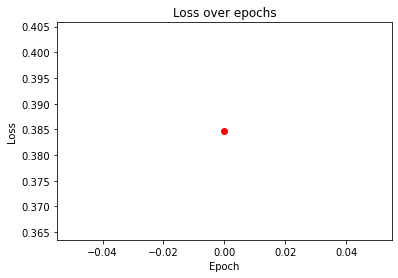

Fold 1/5 | Epoch 2/10
-------------------------------
Using original full data...
Successfully splitted dataset!
 Trainbatches: 100
 Validationbatches: 25
Starting model training...


Training: 100%|██████████| 100/100 [00:26<00:00,  3.85it/s]


Training Error: 
 
        Accuracy: 89.375000%, 

        Recall: 3.947368%, 

        Precision: 20.000000%, 

        Avg loss: 0.349222 

    
Starting model validation...


Evaluating: 100%|██████████| 25/25 [00:02<00:00,  9.78it/s]


Validation Error: 

        Accuracy: 91.000000%, 

        Recall: 0.000000%, 

        Precision: 0.000000%, 

        Avg loss: 0.317436 

    
Val ROC AUC Score: 0.532967032967033


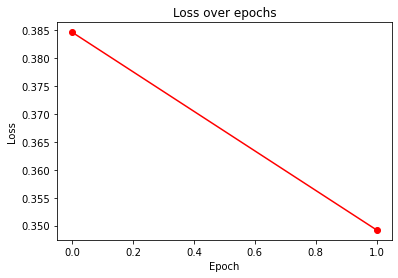

Fold 1/5 | Epoch 3/10
-------------------------------
Using original full data...
Successfully splitted dataset!
 Trainbatches: 100
 Validationbatches: 25
Starting model training...


Training: 100%|██████████| 100/100 [00:26<00:00,  3.81it/s]


Training Error: 
 
        Accuracy: 90.375000%, 

        Recall: 0.000000%, 

        Precision: 0.000000%, 

        Avg loss: 0.327218 

    
Starting model validation...


Evaluating: 100%|██████████| 25/25 [00:02<00:00,  9.45it/s]


Validation Error: 

        Accuracy: 91.000000%, 

        Recall: 0.000000%, 

        Precision: 0.000000%, 

        Avg loss: 0.356284 

    
Val ROC AUC Score: 0.43345543345543347


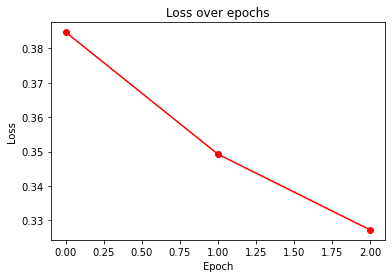

Fold 1/5 | Epoch 4/10
-------------------------------
Using original full data...
Successfully splitted dataset!
 Trainbatches: 100
 Validationbatches: 25
Starting model training...


Training: 100%|██████████| 100/100 [00:26<00:00,  3.83it/s]


Training Error: 
 
        Accuracy: 90.375000%, 

        Recall: 1.315789%, 

        Precision: 33.333333%, 

        Avg loss: 0.308992 

    
Starting model validation...


Evaluating: 100%|██████████| 25/25 [00:02<00:00,  9.44it/s]


Validation Error: 

        Accuracy: 91.000000%, 

        Recall: 0.000000%, 

        Precision: 0.000000%, 

        Avg loss: 0.357787 

    
Val ROC AUC Score: 0.47710622710622713


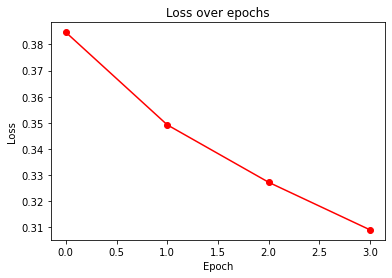

Fold 1/5 | Epoch 5/10
-------------------------------
Using original full data...
Successfully splitted dataset!
 Trainbatches: 100
 Validationbatches: 25
Starting model training...


Training: 100%|██████████| 100/100 [00:26<00:00,  3.82it/s]


Training Error: 
 
        Accuracy: 90.625000%, 

        Recall: 1.315789%, 

        Precision: 100.000000%, 

        Avg loss: 0.289019 

    
Starting model validation...


Evaluating: 100%|██████████| 25/25 [00:02<00:00,  9.45it/s]


Validation Error: 

        Accuracy: 89.500000%, 

        Recall: 5.555556%, 

        Precision: 20.000000%, 

        Avg loss: 0.339494 

    
Val ROC AUC Score: 0.6669719169719169


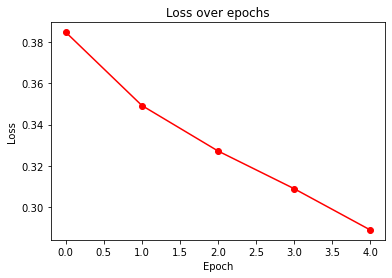

Fold 1/5 | Epoch 6/10
-------------------------------
Using original full data...
Successfully splitted dataset!
 Trainbatches: 100
 Validationbatches: 25
Starting model training...


Training: 100%|██████████| 100/100 [00:26<00:00,  3.84it/s]


Training Error: 
 
        Accuracy: 90.375000%, 

        Recall: 0.000000%, 

        Precision: 0.000000%, 

        Avg loss: 0.285149 

    
Starting model validation...


Evaluating: 100%|██████████| 25/25 [00:02<00:00,  9.60it/s]


Validation Error: 

        Accuracy: 91.000000%, 

        Recall: 0.000000%, 

        Precision: 0.000000%, 

        Avg loss: 0.393424 

    
Val ROC AUC Score: 0.5106837606837606


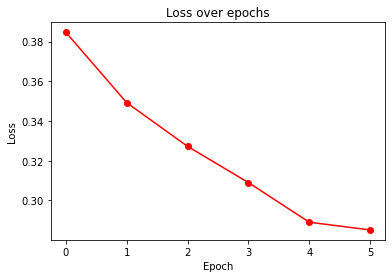

Fold 1/5 | Epoch 7/10
-------------------------------
Using original full data...
Successfully splitted dataset!
 Trainbatches: 100
 Validationbatches: 25
Starting model training...


Training: 100%|██████████| 100/100 [00:26<00:00,  3.81it/s]


Training Error: 
 
        Accuracy: 90.625000%, 

        Recall: 1.315789%, 

        Precision: 100.000000%, 

        Avg loss: 0.297600 

    
Starting model validation...


Evaluating: 100%|██████████| 25/25 [00:02<00:00,  9.43it/s]

Validation Error: 

        Accuracy: 91.000000%, 

        Recall: 0.000000%, 

        Precision: 0.000000%, 

        Avg loss: 0.426491 

    
Val ROC AUC Score: 0.5534188034188035


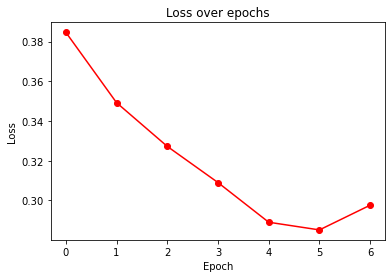

Fold 1/5 | Epoch 8/10
-------------------------------
Using original full data...
Successfully splitted dataset!
 Trainbatches: 100
 Validationbatches: 25
Starting model training...


Training: 100%|██████████| 100/100 [00:26<00:00,  3.78it/s]


Training Error: 
 
        Accuracy: 90.375000%, 

        Recall: 1.315789%, 

        Precision: 33.333333%, 

        Avg loss: 0.266692 

    
Starting model validation...


Evaluating: 100%|██████████| 25/25 [00:02<00:00,  9.17it/s]


Validation Error: 

        Accuracy: 91.000000%, 

        Recall: 0.000000%, 

        Precision: 0.000000%, 

        Avg loss: 0.396675 

    
Val ROC AUC Score: 0.467948717948718


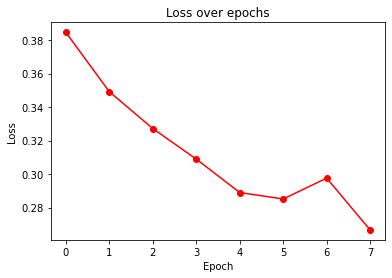

Fold 1/5 | Epoch 9/10
-------------------------------
Using original full data...
Successfully splitted dataset!
 Trainbatches: 100
 Validationbatches: 25
Starting model training...


Training: 100%|██████████| 100/100 [00:27<00:00,  3.60it/s]


Training Error: 
 
        Accuracy: 90.625000%, 

        Recall: 2.631579%, 

        Precision: 66.666667%, 

        Avg loss: 0.251893 

    
Starting model validation...


Evaluating: 100%|██████████| 25/25 [00:02<00:00,  9.13it/s]


Validation Error: 

        Accuracy: 90.000000%, 

        Recall: 0.000000%, 

        Precision: 0.000000%, 

        Avg loss: 0.437449 

    
Val ROC AUC Score: 0.5393772893772895


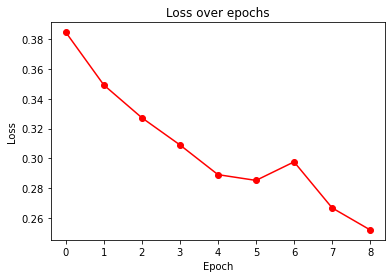

Fold 1/5 | Epoch 10/10
-------------------------------
Using original full data...
Successfully splitted dataset!
 Trainbatches: 100
 Validationbatches: 25
Starting model training...


Training: 100%|██████████| 100/100 [00:27<00:00,  3.61it/s]


Training Error: 
 
        Accuracy: 90.625000%, 

        Recall: 11.842105%, 

        Precision: 52.941176%, 

        Avg loss: 0.251782 

    
Starting model validation...


Evaluating: 100%|██████████| 25/25 [00:02<00:00,  9.85it/s]

Validation Error: 

        Accuracy: 90.500000%, 

        Recall: 0.000000%, 

        Precision: 0.000000%, 

        Avg loss: 0.521432 

    
Val ROC AUC Score: 0.4252136752136752


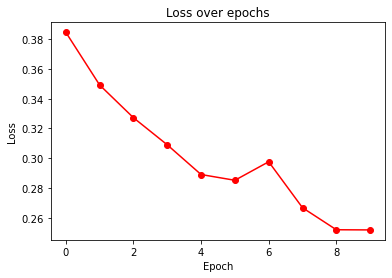

Training done! Best model in fold 0, epoch 4 with roc_auc of 0.6669719169719169


In [110]:
df_train = pd.read_csv(conf_dict["input_dir"] + conf_dict["train_csv"])
if not conf_dict["use_all"]:
    df_train = df_train[:conf_dict["only_use"]]
df_train["file_path"] = df_train["id"].apply(get_file_path, directory=conf_dict["train_dir"])

loss_fn = nn.BCEWithLogitsLoss()
num_epochs = conf_dict["epochs"]
num_folds = conf_dict["folds"]
skf = StratifiedKFold(n_splits=num_folds)

with codecs.open('logs/schnaufNet2.0 train.log', 'a') as up:
    up.write("------------------ new training ------------------")
with codecs.open('logs/schnaufNet2.0 validation.log', 'a') as up:
    up.write("------------------ new validation ------------------")

for fold, (train_index, val_index) in enumerate(skf.split(df_train, df_train["target"])):
    model = EfficientNetBackbone(out_dim=1, load_schnaufnet_model=conf_dict["load_model"])
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=conf_dict["learn_rate"], weight_decay=conf_dict["weight_decay"]) # torch.optim.SGD(model.parameters(), lr=conf_dict["learn_rate"]) 
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=conf_dict["epochs"], eta_min=conf_dict["min_learn_rate"], last_epoch=-1
    )
    best_roc_auc = 0
    best_roc_auc_fold = 1
    best_roc_auc_fold_epoch = 1
    epoch_train_loss_list = []
    for epoch in range(num_epochs):
        print(f"Fold {fold + 1}/{num_folds} | Epoch {epoch + 1}/{num_epochs}\n-------------------------------")
        # if epoch == math.floor(num_epochs * conf_dict["split_until_ratio"]):
        #     train_dataloader, val_dataloader = split(train_index, val_index, behaviour=new_split_behaviour)
        # else:
        #     train_dataloader, val_dataloader = split(train_index, val_index, behaviour=current_split_behaviour)
        train_dataloader, val_dataloader = split(train_index, val_index, behaviour=conf_dict["behaviours"]["all"]) # only behaviour 'all'
        train_loop(model, train_dataloader, optimizer, loss_fn, scheduler, epoch_train_loss_list)
        val_labels, val_predictions = validation_loop(model, val_dataloader, loss_fn)
        roc_auc = metrics.roc_auc_score(val_labels, val_predictions)
        print(f"Val ROC AUC Score: {roc_auc}")
        with codecs.open('logs/schnaufNet2.0 validation.log', 'a') as up:
            up.write(f"""
                Epoch={epoch}, Valid ROC AUC={roc_auc}\n
            """)
        if roc_auc > best_roc_auc:
            torch.save(model.state_dict(), "best_roc_auc_" + conf_dict["model"] + "-" + str(fold) + "-" + str(epoch) + ".pth")
            best_roc_auc = roc_auc
            best_roc_auc_fold = fold
            best_roc_auc_epoch = epoch
        plt.plot(epoch_train_loss_list, "ro-")
        plt.title("Loss over epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()
    break # for test purposes only one fold
print(f"Training done! Best model in fold {best_roc_auc_fold}, epoch {best_roc_auc_epoch} with roc_auc of {best_roc_auc}")